In [ ]:
!pip install wordcloud
!pip install spellchecker
!pip install mlxtend

### Exploratory analysis

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from copy import copy

sns.set(style='darkgrid')

In [3]:
# data reading
raw_sms_df = pd.read_csv('./data/sms_senior.csv')

In [4]:
# separating terms frequency data from the remaining
compact_sms_df = raw_sms_df[['Full_Text','Common_Word_Count', 'Word_Count', 'Date', 'IsSpam' ]]

# keeps only the frequency of the most frequent terms
terms_count_df = raw_sms_df.drop(compact_sms_df, axis=1)
terms_frequency = {k: v for k, v in sorted(terms_count_df.sum().to_dict().items(), key=lambda item: item[1], reverse=True)}

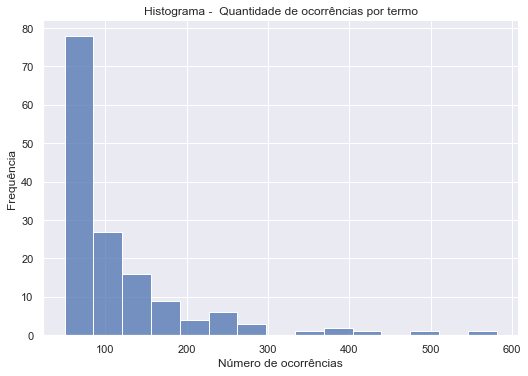

In [5]:
# histogram ploting
fig = sns.displot(terms_frequency, bins=15, kind='hist', height=5, aspect=1.5)
fig.set(xlabel='Número de ocorrências', ylabel='Frequência', title='Histograma -  Quantidade de ocorrências por termo')
plt.show()

In [6]:
# validating if terms occurrences consider only certain words (the most frequent)
word_occurences = pd.DataFrame(columns=['count'])
word_occurences['count'] = terms_count_df.sum(axis=1)
word_occurences['commom'] = raw_sms_df['Common_Word_Count']
word_occurences[word_occurences['count'] == word_occurences['commom']].shape

print('Quantidade de linhas na base original:', raw_sms_df.shape[0])
print('Quantidade de linhas no teste:', word_occurences.shape[0])

Quantidade de linhas na base original: 5574
Quantidade de linhas no teste: 5574


### Visualizations

In [7]:
pd.options.mode.chained_assignment = None

In [8]:
def plot_cloud(cloud, title):
    plt.figure(figsize=(16,10))
    plt.imshow(cloud)
    plt.title(title)
    plt.axis('off')

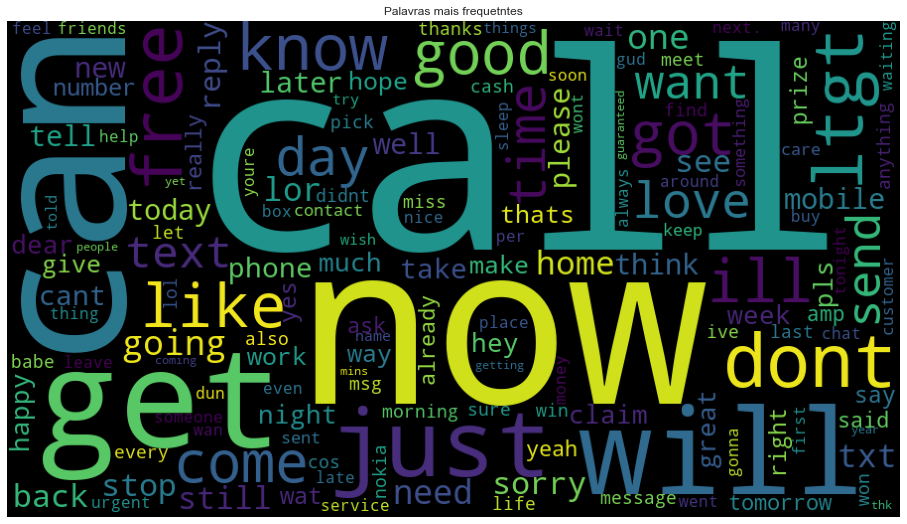

In [9]:
# word cloud ploting
wordcloud = WordCloud(width=900, height=500, relative_scaling=1).generate_from_frequencies(terms_count_df.sum().to_dict())
plot_cloud(wordcloud, 'Palavras mais frequetntes')

In [10]:
compact_sms_df['Date'] = compact_sms_df['Date'].apply(lambda x: str(x).split(' ')[0])
compact_sms_df['Date'] = pd.to_datetime(compact_sms_df['Date'],  format='%Y-%m-%d')
compact_sms_df = compact_sms_df.set_index('Date')
# compact_sms_df.head()

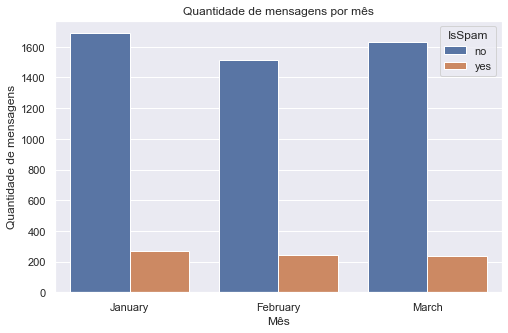

In [11]:
grouping = compact_sms_df.groupby(['IsSpam', pd.Grouper(freq='M')])

plot_df = grouping.count().reset_index()
plot_df['Date'] = plot_df['Date'].apply(lambda x: x.month_name())

fig, ax = plt.subplots(figsize=(8,5))
g = sns.barplot(data=plot_df, x='Date', y ='Word_Count', hue='IsSpam', ax=ax )
g.set(xlabel='Mês', ylabel='Quantidade de mensagens', title='Quantidade de mensagens por mês')
plt.show()

In [12]:
statistics_df = grouping.agg({'IsSpam': 'count', 'Word_Count': ['sum', 'min', 'max', 'mean', 'median', 'std', 'var']})
statistics_df

IsSpam Word_Count                                        \
                   count        sum min  max       mean median        std   
IsSpam Date                                                                 
no     2017-01-31   1687      25081   2  190  14.867220     11  12.728394   
       2017-02-28   1512      22019   2  100  14.562831     11  10.966891   
       2017-03-31   1628      24285   2  115  14.917076     11  11.532744   
yes    2017-01-31    266       6825   3   36  25.657895     27   5.456472   
       2017-02-28    244       6128   5   36  25.114754     26   6.042642   
       2017-03-31    237       6087   2   39  25.683544     27   6.315593   

                               
                          var  
IsSpam Date                    
no     2017-01-31  162.012015  
       2017-02-28  120.272688  
       2017-03-31  133.004183  
yes    2017-01-31   29.773088  
       2017-02-28   36.513526  
       2017-03-31   39.886720

In [13]:
max_df = copy(compact_sms_df).reset_index()
max_df = max_df[max_df['IsSpam'] == 'no'] # selecting not spam data
max_df['Month'] = max_df['Date'].apply(lambda x: x.month_name())

max_df = max_df.groupby(['Month', 'Date']).count() # count the e-mail ocurrences by date for each month
max_df = max_df.rename(columns={'Full_Text': 'Count'})['Count'] 

max_df.sort_values().groupby(level=0).tail(1) # group by month index, order by number of ocurrences and get the last one

Month     Date      
March     2017-03-08    69
January   2017-01-01    69
February  2017-02-13    72
Name: Count, dtype: int64

### Analysis

#### Pre-processing

In [14]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from copy import copy
import numpy as np

In [15]:
# pre-processing steps
def lower_casing(text):
    return text.lower()

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = ' '.join([t for t in text.split(' ') if t not in stop_words])
    return text

def remove_symbols(text):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n,"
    for s in symbols:
        text = np.char.replace(text, s, '')
    return text

def remove_single_chars(text):
    text = ' '.join([t for t in text.split(' ') if len(t) > 1])
    return text

def lemmatization(text):
    wnLemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    new_tokens = [wnLemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(new_tokens)

In [16]:
# applying pre-processing in Full Text Column
preprocessed_df = copy(raw_sms_df[['Full_Text', 'Common_Word_Count',  'Word_Count',  'Date',  'IsSpam']])

preprocessed_df['Full_Text'] = preprocessed_df['Full_Text'].apply(lower_casing)
preprocessed_df['Full_Text'] = preprocessed_df['Full_Text'].apply(remove_stopwords)
preprocessed_df['Full_Text'] = preprocessed_df['Full_Text'].apply(remove_symbols)
preprocessed_df['Full_Text'] = preprocessed_df['Full_Text'].apply(remove_single_chars)
preprocessed_df['Full_Text'] = preprocessed_df['Full_Text'].apply(lemmatization)

#### Modeling

In [17]:
X = copy(preprocessed_df)
y = pd.Categorical(X.pop('IsSpam')).codes

In [ ]:
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

# random forest parameters used in tunning
rf_parameters = {'random_forest__n_estimators':[50, 100, 200, 300, 400],
                'random_forest__random_state': [1]}

# logistic regression parameters used in tunning
lr_parameters = {'logistic_regression__solver': ['liblinear'],
                'logistic_regression__penalty': ['l1', 'l2'],
                'logistic_regression__max_iter': [50,100,200, 300],
                'logistic_regression__random_state': [1]}

# SVM parameters used in tunning
svm_parameters = {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'svm__gamma': [1,0.1,0.01,0.001],
                'svm__C': [0.1,1, 10, 100],
                'svm__random_state': [1]}

models = [('random_forest', RandomForestClassifier(), rf_parameters),
         ('logistic_regression', LogisticRegression(), lr_parameters),
         ('svm', SVC(), svm_parameters)]

metrics_df = pd.DataFrame()

# iterating over models and their respective parameters
for model in models:

    
    pipe = Pipeline([
        ('column_selector', ColumnSelector(cols=('Full_Text'), drop_axis=True)),
        ('tfidf', TfidfVectorizer()),
        (model[0], model[1]),
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # tunning the model parameters
    grid = GridSearchCV(pipe, model[2],  
                    scoring = ['accuracy', 'precision', 'recall', 'f1'], 
                    refit='accuracy',
                    cv = 5)

    grid.fit(X_train, y_train)
    
    grid_df = pd.DataFrame(grid.cv_results_)
    grid_df['model'] = model[0]
    metrics_df = metrics_df.append(grid_df)

/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amanda/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classi

In [ ]:
svm_columns = ['params', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel', 'param_svm__random_state', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']
svm_result = metrics_df[metrics_df['model'] == 'svm'].sort_values('mean_test_f1', ascending=False)[svm_columns]
display(svm_result.head(5))

In [ ]:
rf_columns = ['param_random_forest__n_estimators', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']
rf_result = metrics_df[metrics_df['model'] == 'random_forest'].sort_values('mean_test_f1', ascending=False)[rf_columns]
display(rf_result.head(5))

In [ ]:
lr_columns = ['param_logistic_regression__solver', 'param_logistic_regression__penalty', 'param_logistic_regression__max_iter', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']
lr_result = metrics_df[metrics_df['model'] == 'logistic_regression'].sort_values('mean_test_f1', ascending=False)[lr_columns]
display(lr_result.head(5))

In [ ]:
from sklearn.metrics import confusion_matrix

labels_dict = {0: 'Comum', 1: 'Spam'}

# generic method used to plot a confusion matrix
def plot_confusion_matrix(real, predicted, title, ax=None, cmap='Blues'):
    ticks = copy(list(predicted))
    ticks.extend(list(real))
    ticks = np.unique(ticks)
    ticks = [labels_dict[tick] for tick in set(ticks)]
    
    cm =  confusion_matrix(real, predicted, normalize='true')
    cm = pd.DataFrame(cm, index=ticks, columns=ticks)
    
    if ax:
        sns.heatmap(cm, annot=True, cmap=cmap, fmt='.2f', ax=ax)
        ax.set_title(title)  
    else:    
        plt.figure(figsize = (10,7))
        sns.heatmap(cm, annot=True, cmap=cmap, fmt='.2f')
        plt.title(title)
        plt.show()

In [ ]:
# defining the pipeline using the SVM paremeters that gave the best results
pipe = Pipeline([
        ('column_selector', ColumnSelector(cols=('Full_Text'), drop_axis=True)),
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC(C=100, gamma=0.001, kernel='linear', random_state=1)),
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_confusion_matrix(y_test, y_pred, 'Matriz de Confusão', ax=ax)